# YEAST PPI 


### PIPELINE OVERVIEW
+ graph with genes as nodes and edges
+ generate a matrix from nodes based on specific parameters (features, random walk, shortest path..)
+ multidimensional matrices > embedding with tsne into 2D or 3D 
----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE 
______________

In [2]:
from multidimvis_main import * 

In [3]:
organism = 'yeast'

In [4]:
data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
#df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})


no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']
G = G_cere

#edge_list = nx.write_edgelist(G, "Yeast_edgelist_directinteractiononly.txt")

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


# GRAPH PROPERTIES

In [5]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 5785
Number of edges: 31237
Network density: 0.2%


#### Degree Distribution 

In [ ]:
l_k = list(degs.values())
set_k = set(l_k)
print('Degree min:', min(l_k))
print('Degree max:', max(l_k))

d_k_f = {}
for k in set_k:
    d_k_f[k] = l_k.count(k)
#print('Degree counts:',d_k_f)

mean_deg = np.mean(l_k)
var_deg = np.var(l_k)
print('Degree Mean:', mean_deg)
print('Degree Variant:', var_deg)

plt.figure(figsize=(10,10))
plt.title('Degree Distribution', fontsize = 20)
plt.xlabel('Degree', fontsize = 14)
plt.ylabel('P(k)', fontsize = 14)
plt.loglog(list(d_k_f.keys()),list(d_k_f.values()),'o',c='#008CA0')
plt.show()

#plt.savefig('PPIdegreedist.png')

# FEATURE COLLECTION

#### + TOPOLOGICAL FEATURES
##### based on: https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html
+ degree centrality
+ closeness centrality
+ betweeness centrality
+ eigenvector centrality

In [ ]:
%%time 

# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)

In [ ]:
%%time 

# CLOSENESS CENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)

In [ ]:
%%time

# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)

In [ ]:
%%time 

# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

### Feature Collection without Score

In [9]:
feature_df = pd.read_csv('output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),feature_df['degs']))
d_clos = dict(zip(G.nodes(),feature_df['clos']))
d_betw = dict(zip(G.nodes(),feature_df['betw']))
d_eigen = dict(zip(G.nodes(),feature_df['eigen']))

feature_dict = feature_df.to_dict(orient='index')
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}

l_features = [] 
for i in feature_dict_sorted.items():
    k = list(i)
    l_features.append(k)

In [10]:
feature_df.head()

degs    clos    betw   eigen
entrez gene/locuslink:853056  0.0243  0.2729  0.0004  0.0032
entrez gene/locuslink:850930  0.0686  0.3022  0.0007  0.0101
entrez gene/locuslink:854123  0.0708  0.3165  0.0020  0.0212
entrez gene/locuslink:856771  0.0354  0.3064  0.0003  0.0087
entrez gene/locuslink:851205  0.0996  0.3517  0.0023  0.0614

# Score System 

+ HUBS SCORE

In [7]:
# Hub Score 

cutoff = 1 # number of considered hub nodes 
d_hub_nodes = identify_hubs(d_deghubs, d_clos, d_betw, cutoff)

+ ESSENTIALITY SCORE

In [8]:
# Essentiality Score

essentials = []
for i in ess_id:
    essentials.append('entrez gene/locuslink:'+str(i))
    
nonessentials = []
for i in no_ess_id:
    nonessentials.append('entrez gene/locuslink:'+str(i))
    
major_score = 1
minor_score = 0.5 

d_essentiality_scores = node_essentiality_scores(G, essentials, nonessentials, major_score, minor_score)
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in G.nodes()}

### Feature Collection with Score

In [ ]:
feature_df['essentiality'] = list(d_essentiality_scores_sorted.values())

feature_dict = feature_df.to_dict(orient='index')
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}

l_features = [] 
for i in feature_dict_sorted.items():
    k = list(i)
    l_features.append(k)

In [ ]:
feature_df.head()

### Matrix Calculations (timed)

In [6]:
%%time 

# Aij

A = nx.adjacency_matrix(G)
DM_adj = A.toarray()

CPU times: user 410 ms, sys: 34 ms, total: 444 ms
Wall time: 449 ms


In [ ]:
%%time

# SPL

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = nx.shortest_path_length(G,geneA,geneB)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = Mspl 

In [7]:
%%time

# MARKOV / RWR

# Restart probability
r = .8 # originally 0.8

alpha = 1.0 # indicating "randomness" 

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_ = distance.squareform(distance.pdist(DM_m, 'euclidean'))
DM_m = DM_m_.round(decimals = 2)


# MARKOV / RWR -log

#min_log = lambda t: -np.log(t)
#DM_mlog = np.array([min_log(x/max(x)) for x in DM_m])

CPU times: user 17.9 s, sys: 1.18 s, total: 19.1 s
Wall time: 6.95 s


In [ ]:
%%time

# PW euclidean metric 
DM_eucl = distance.squareform(distance.pdist(feature_df, 'euclidean'))

#### EXPORT MATRICES TO CSV

In [ ]:
'''
organism = 'Yeast'

df_adj = pd.DataFrame(DM_adj, columns = list(G.nodes()), index=list(G.nodes()))
df_spl = pd.DataFrame(DM_spl, columns = list(G.nodes()), index=list(G.nodes()))
df_m = pd.DataFrame(DM_m, columns = list(G.nodes()), index=list(G.nodes()))
df_eucl = pd.DataFrame(DM_eucl, columns = list(G.nodes()), index=list(G.nodes()))

# -----------------------------------------------


# Without Score
df_adj.to_csv(r'output_csv/Adjacency_Dataframe_'+organism+'.csv', index = True)
df_spl.to_csv(r'output_csv/SPL_Dataframe_'+organism+'.csv', index = True)
df_m.to_csv(r'output_csv/RWR_Dataframe_'+organism+'.csv', index = True)
df_eucl.to_csv(r'output_csv/PW_eucl_Dataframe_'+organism+'.csv', index = True)

# With Score
df_adj.to_csv(r'output_csv/Adjacency_Dataframe_'+organism+'_score.csv', index = True)
df_spl.to_csv(r'output_csv/SPL_Dataframe_'+organism+'_score.csv', index = True)
df_m.to_csv(r'output_csv/RWR_Dataframe_'+organism+'_score.csv', index = True)
df_eucl.to_csv(r'output_csv/PW_eucl_Dataframe_'+organism+'_score.csv', index = True)
'''

#### IMPORT MATRICES (dataframe) FROM CSV

In [6]:
# without Score

#DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast.csv', index_col=0)
#DM_spl = pd.read_csv('output_csv/SPL_Dataframe_Yeast.csv', index_col=0)
#DM_m = pd.read_csv('output_csv/RWR_Dataframe_Yeast.csv', index_col=0)
DM_eucl = pd.read_csv('output_csv/PW_eucl_Dataframe_Yeast.csv', index_col=0)

# with Score
# DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)
# DM_spl = pd.read_csv('output_csv/SPL_Dataframe_Yeast_score.csv', index_col=0)
# DM_m_ = pd.read_csv('output_csv/RWR_Dataframe_Yeast_score.csv', index_col=0)
# DM_eucl = pd.read_csv('output_csv/PW_eucl_Dataframe_Yeast_score.csv', index_col=0)

____________
# VISUALIZATION SETTINGS

### Size parameter

In [22]:
node_factor = 1
size = draw_node_degree(G, node_factor) # node size based on degree
#size = 15

edge_color = 'grey'
edge_width = 0.1

opacity_nodes = 0.6
opacity_edges = 0.3
node_edge_col = 'dimgrey'

### Colour parameters

+ HUBS COLOR

In [ ]:
# NODE COLORS based on HUBS 

colours = colorfactor_majornodes(G, d_hub_nodes)
edge_color = colorfactor_majornodes_outgoingedges(G, d_hub_nodes)

+ ESSENTIALITY COLOR 

In [ ]:
# NODE COLORS based on Essentiality 

ess_col = 'steelblue' # 'rgba(66, 117, 154, 0.6)'
no_ess_col = 'lightsteelblue' # 'rgba(162, 193, 216, 0.6)'

essentials = list(ess_id)
nonessentials = list(no_ess_id)

colours = color_essentiality_nodes(G, essentials, nonessentials, ess_col, no_ess_col)
edge_color = color_essentiality_edges(G, essentials, nonessentials, ess_col, no_ess_col)

+ CLOSENESS CENTRALITY COLOR 

In [23]:
# Define colour parameter
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
palette = sns.color_palette('Reds', colour_count)

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours = l_col_clos 

# 2D PORTRAITS

#### 2D SPRING

In [ ]:
%%time

posG_spring = nx.spring_layout(G)

plt.figure(figsize=(18,18))
plt.title('Organic spring', size=16)
plt.box(False)
nx.draw_networkx_nodes(G, posG_spring,
                       edgecolors = node_edge_col, 
                       linewidths = 0.5, 
                       node_color='lightgrey', node_size=1)
nx.draw_networkx_edges(G, pos = posG_spring, width = edge_width, edge_color = 'lightgrey', alpha = opacity_edges)
print('Network: ', organism)
print('Number of Nodes:', len(G.nodes()))

plt.savefig('output_plots/Organic_spring_layout2D_'+organism+'.png')
plt.show()

### tSNE EMBEDDING 2D

In [30]:
prplxty = 100 # range: 5-50 / default = 30
density = 1.4 # default 12.
l_rate = 200 # default 200.
steps = 250 # min 250
metric = 'euclidean'

In [ ]:
%%time
tsne_adj = embed_tsne_2D(DM_adj, prplxty, density, l_rate, steps, metric)
posG_tsne_adj = get_posG(G,tsne_adj)

In [ ]:
%%time
tsne_spl = embed_tsne_2D(DM_spl, prplxty, density, l_rate, steps, metric)
posG_tsne_spl = get_posG(G,tsne_spl)

In [ ]:
%%time
tsne_m = embed_tsne_2D(DM_m.T, prplxty, density, l_rate, steps, metric)
posG_tsne_m = get_posG(G,tsne_m)

In [31]:
%%time
tsne_eucl = embed_tsne_2D(DM_eucl, prplxty, density, l_rate, steps, metric)
posG_tsne_eucl = get_posG(G,tsne_eucl)

CPU times: user 2min 52s, sys: 4.59 s, total: 2min 57s
Wall time: 1min 25s


### 2D tSNE PORTRAITS

In [ ]:
plt.figure(figsize=(25,25))
plt.title('Adj | t-SNE | Metric: '+ metric, size= 16)

nx.draw_networkx_nodes(G, posG_tsne_adj, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_tsne_adj, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_adj, font_size = fontsize_labels, font_color = 'black')
plt.box(False)

plt.savefig('output_plots/2Dtsne_adj_'+metric+'_'+organism+'.png')

plt.show()

In [ ]:
plt.figure(figsize=(25,25))
plt.title('SPL | t-SNE | Metric: '+ metric, size=16)

nx.draw_networkx_nodes(G, posG_tsne_spl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_tsne_spl, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_spl, font_size = fontsize_labels, font_color = 'black')
plt.box(False)

plt.savefig('output_plots/2Dtsne_spl_'+metric+'_'+organism+'.png')

plt.show()

In [ ]:
plt.figure(figsize=(25,25))
plt.title('Markov | t-SNE | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_tsne_m, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_tsne_m, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtsne_m_'+metric+'_'+ organism +'.png')

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



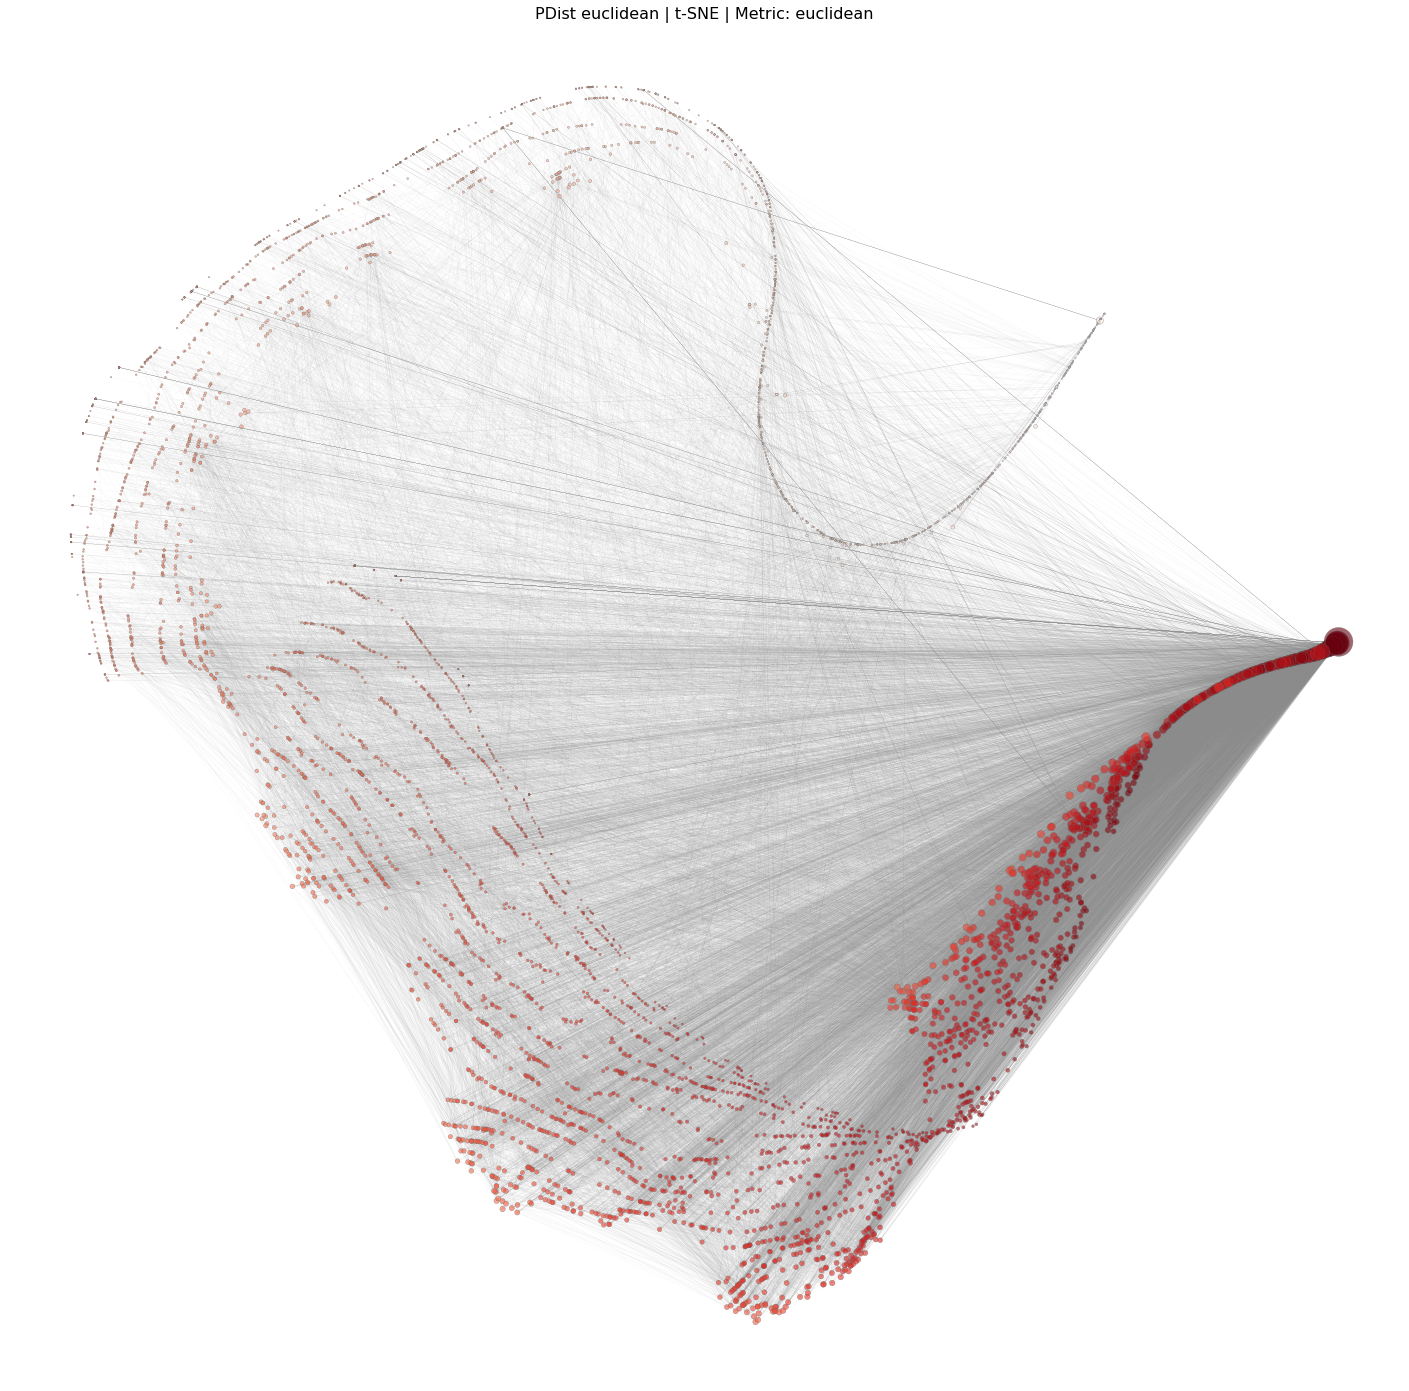

In [32]:
plt.figure(figsize=(25,25))
plt.title('PDist euclidean | t-SNE | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_tsne_eucl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_tsne_eucl, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtsne_eucl_'+metric+'_'+organism+'.png')

plt.show()

### UMAP EMBEDDING 2D 
+https://umap-learn.readthedocs.io/en/latest/embedding_space.html

In [101]:
n_neighbors = 30 # balance between local and global structure in the data
spread = 6.
min_dist = 0.5 # defines how dense points are stacked together 
n_components = 2 # for 2D

U = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric)

In [ ]:
%%time 
umap_adj = U.fit_transform(DM_adj)
posG_umap_adj = get_posG(G,umap_adj)

In [ ]:
%%time 
umap_spl = U.fit_transform(DM_spl)
posG_umap_spl = get_posG(G,umap_spl)

In [ ]:
%%time 
umap_m = U.fit_transform(DM_m)
posG_umap_m = get_posG(G, umap_m)

In [102]:
%%time 
umap_eucl = U.fit_transform(DM_eucl)
posG_umap_eucl = get_posG(G, umap_eucl)

/opt/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1157: RuntimeWarning:

divide by zero encountered in power



CPU times: user 33.9 s, sys: 1.16 s, total: 35.1 s
Wall time: 11.9 s


### 2D UMAP PORTRAITS

In [ ]:
plt.figure(figsize=(25,25))
plt.title('Adj | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_umap_adj, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_umap_adj, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_umap_adj, font_size = fontsize_labels, font_color = 'black')
plt.box(False)

plt.savefig('output_plots/2Dumap_adj_'+metric+'_'+organism+'.png')

plt.show()

In [ ]:
plt.figure(figsize=(25,25))
plt.title('SPL | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_umap_spl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_umap_spl, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_umap_spl, font_size = fontsize_labels, font_color = 'black')
plt.box(False)

plt.savefig('output_plots/2Dumap_spl_'+metric+'_'+organism+'.png')

plt.show()

In [ ]:
plt.figure(figsize=(25,25))
plt.title('Markov | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_umap_m, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_umap_m, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_umap_spl, font_size = fontsize_labels, font_color = 'black')
plt.box(False)

plt.savefig('output_plots/2Dumap_m_'+metric+'_'+organism+'.png')

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



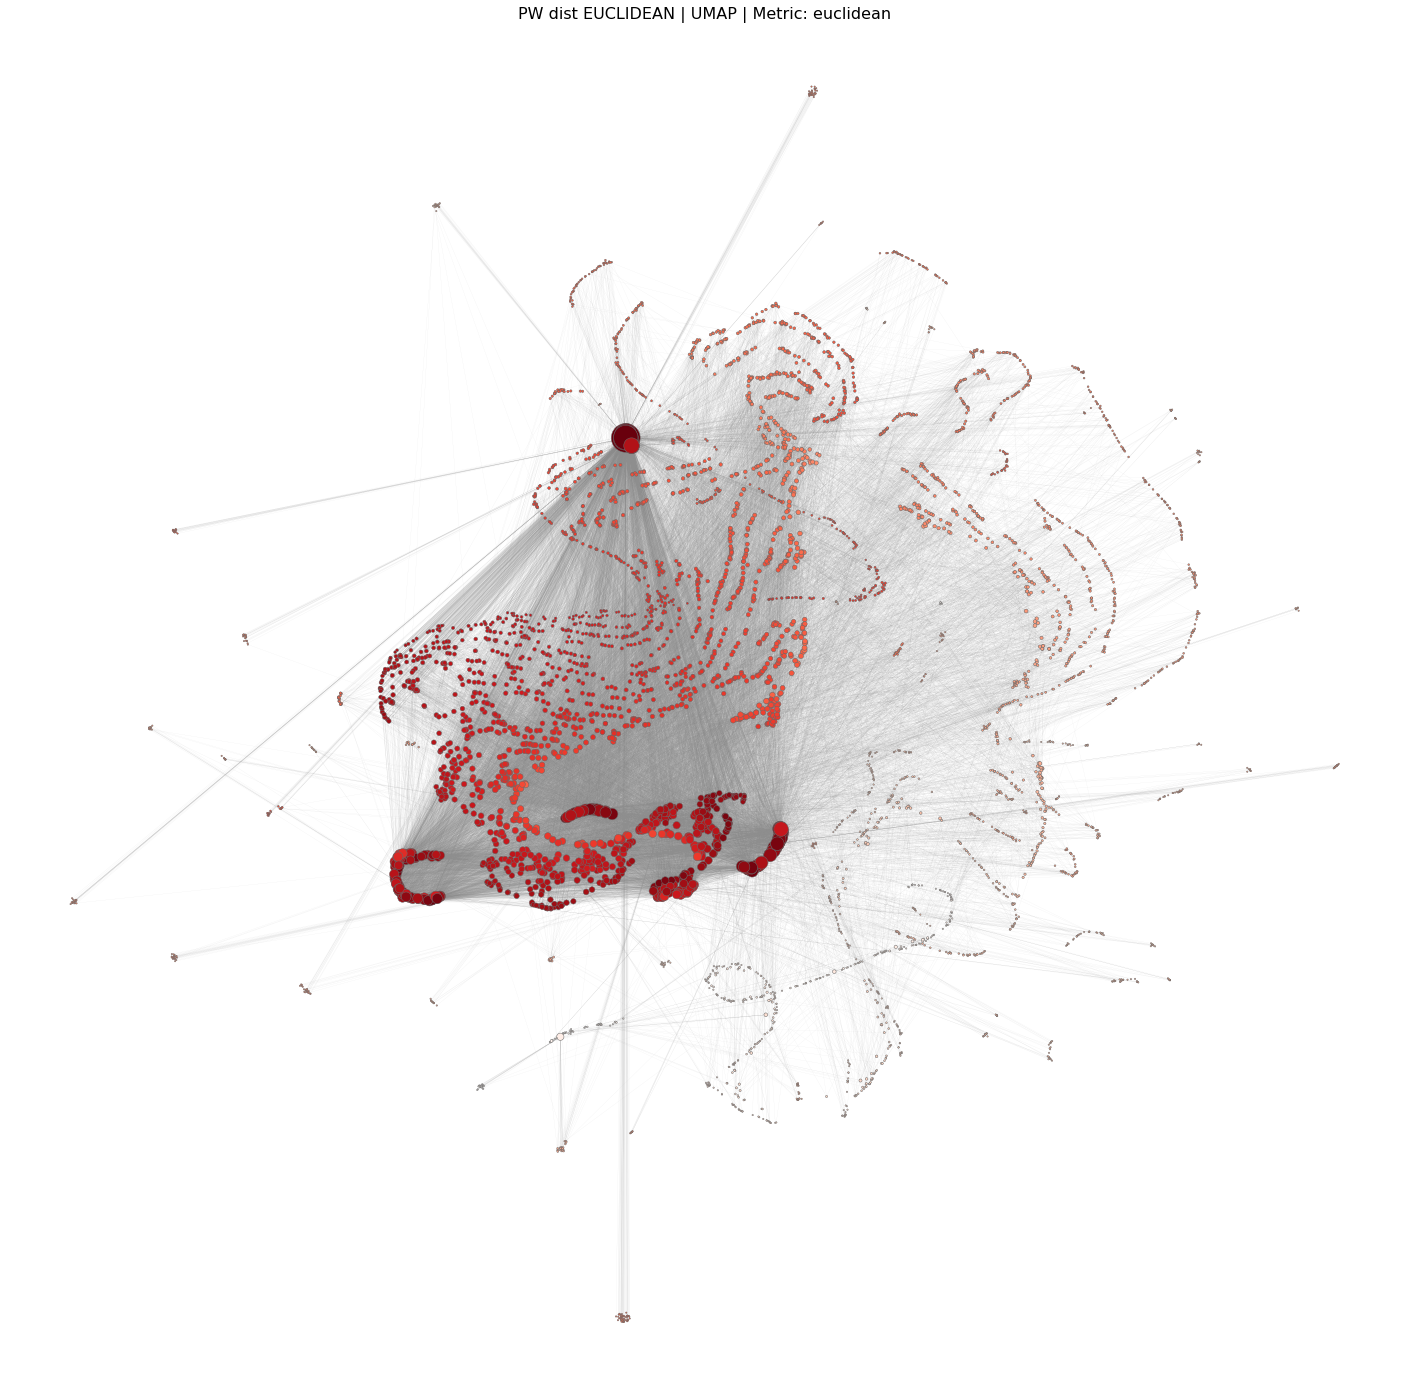

In [103]:
plt.figure(figsize=(25,25))
plt.title('PW dist EUCLIDEAN | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_umap_eucl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = 1)
nx.draw_networkx_edges(G, pos = posG_umap_eucl, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_umap_spl, font_size = fontsize_labels, font_color = 'black')
plt.box(False)

plt.savefig('output_plots/2Dumap_eucl_'+metric+'_'+organism+'.png')

plt.show()

____________
# 3D

### 3D Visualization Settings

In [104]:
edge_color = 'grey'
#edge_color = 'dimgrey'

# LANDSCAPES

In [105]:
#dict_z = {key:d_essentiality_scores[key] for key in G.nodes()}
dict_z = {key:d_clos[key] for key in G.nodes()}

z_list = list(dict_z.values())

z_list_mod = []
for i in z_list:
    z_list_mod.append(i*500)

In [106]:
z_list = z_list_mod

In [92]:
node_factor = 0.04 # node size factor
size3d = draw_node_degree(G, node_factor)
#size3d = 5

### tSNE

In [ ]:
%%time

tsne_adj_x, tsne_adj_y, tsne_adj_z = get_coords_landscape(G, posG_tsne_adj)
tsne_adj_trace_z = get_trace_nodes_landscape(tsne_adj_x, tsne_adj_y, z_list, colours, size3d)
tsne_data_adj = [tsne_adj_trace_z] #,adj_edges]

In [ ]:
%%time

tsne_spl_x, tsne_spl_y, tsne_spl_z = get_coords_landscape(G, posG_tsne_spl)
tsne_spl_trace_z = get_trace_nodes_landscape(tsne_spl_x, tsne_spl_y, z_list, colours, size3d)
tsne_data_spl = [tsne_spl_trace_z] #, spl_edges]%%time

In [ ]:
%%time

tsne_m_x, tsne_m_y, tsne_m_z = get_coords_landscape(G, posG_tsne_m)
tsne_m_trace_z = get_trace_nodes_landscape(tsne_m_x, tsne_m_y, z_list, colours, size3d)
tsne_data_m = [tsne_m_trace_z] #,mlog_edges]

In [ ]:
%%time 

tsne_eucl_x, tsne_eucl_y, tsne_eucl_z = get_coords_landscape(G, posG_tsne_eucl)
tsne_eucl_trace_z = get_trace_nodes_landscape(tsne_eucl_x, tsne_eucl_y, z_list, colours, size3d)
tsne_data_eucl = [tsne_eucl_trace_z] #,eucl_edges]

In [ ]:
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)


fig_1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | t-SNE | Metric: '+ metric, 
                                                     'SPL | t-SNE | Metric: '+ metric,
                                                     'Markov | t-SNE | Metric: '+ metric,
                                                      'PW Euclidean | tSNE | Metric: '+ metric)
                    )

    
for i in tsne_data_adj:
    fig_1.add_trace(i, row = 1, col = 1)


for i in tsne_data_spl:
    fig_1.add_trace(i, row = 1, col = 2)
    
for i in tsne_data_m:
    fig_1.add_trace(i, row = 1, col = 3)

for i in tsne_data_eucl:
    fig_1.add_trace(i, row = 1, col = 4)

fig_1.update_layout(template='plotly_dark', height = 1000, width = 2200)
#fig_1.update_layout(template=None, height = 1000, width = 2200)
py.iplot(fig_1)

plotly.offline.plot(fig_1, filename = 'output_plots/Landscapes_tsne_'+metric+'_'+organism+'.html', auto_open=False)

### UMAP

In [107]:
size3d = 2

In [ ]:
%%time

umap_adj_x, umap_adj_y, umap_adj_z = get_coords_landscape(G, posG_umap_adj)
umap_adj_trace_z = get_trace_nodes_landscape(umap_adj_x, umap_adj_y, z_list, colours, size3d)
umap_data_adj = [umap_adj_trace_z]

In [ ]:
%%time

umap_spl_x, umap_spl_y, umap_spl_z = get_coords_landscape(G, posG_umap_spl)
umap_spl_trace_z = get_trace_nodes_landscape(umap_spl_x, umap_spl_y, z_list, colours, size3d)
umap_data_spl = [umap_spl_trace_z]

In [ ]:
%%time

umap_m_x, umap_m_y, umap_m_z = get_coords_landscape(G, posG_umap_m)
umap_m_trace_z = get_trace_nodes_landscape(umap_m_x, umap_m_y, z_list, colours, size3d)
umap_data_m = [umap_m_trace_z]

In [108]:
%%time

umap_eucl_x, umap_eucl_y, umap_eucl_z = get_coords_landscape(G, posG_umap_eucl)
umap_eucl_trace_z = get_trace_nodes_landscape(umap_eucl_x, umap_eucl_y, z_list, colours, size3d)
umap_data_eucl = [umap_eucl_trace_z]

CPU times: user 708 ms, sys: 6.53 ms, total: 714 ms
Wall time: 716 ms


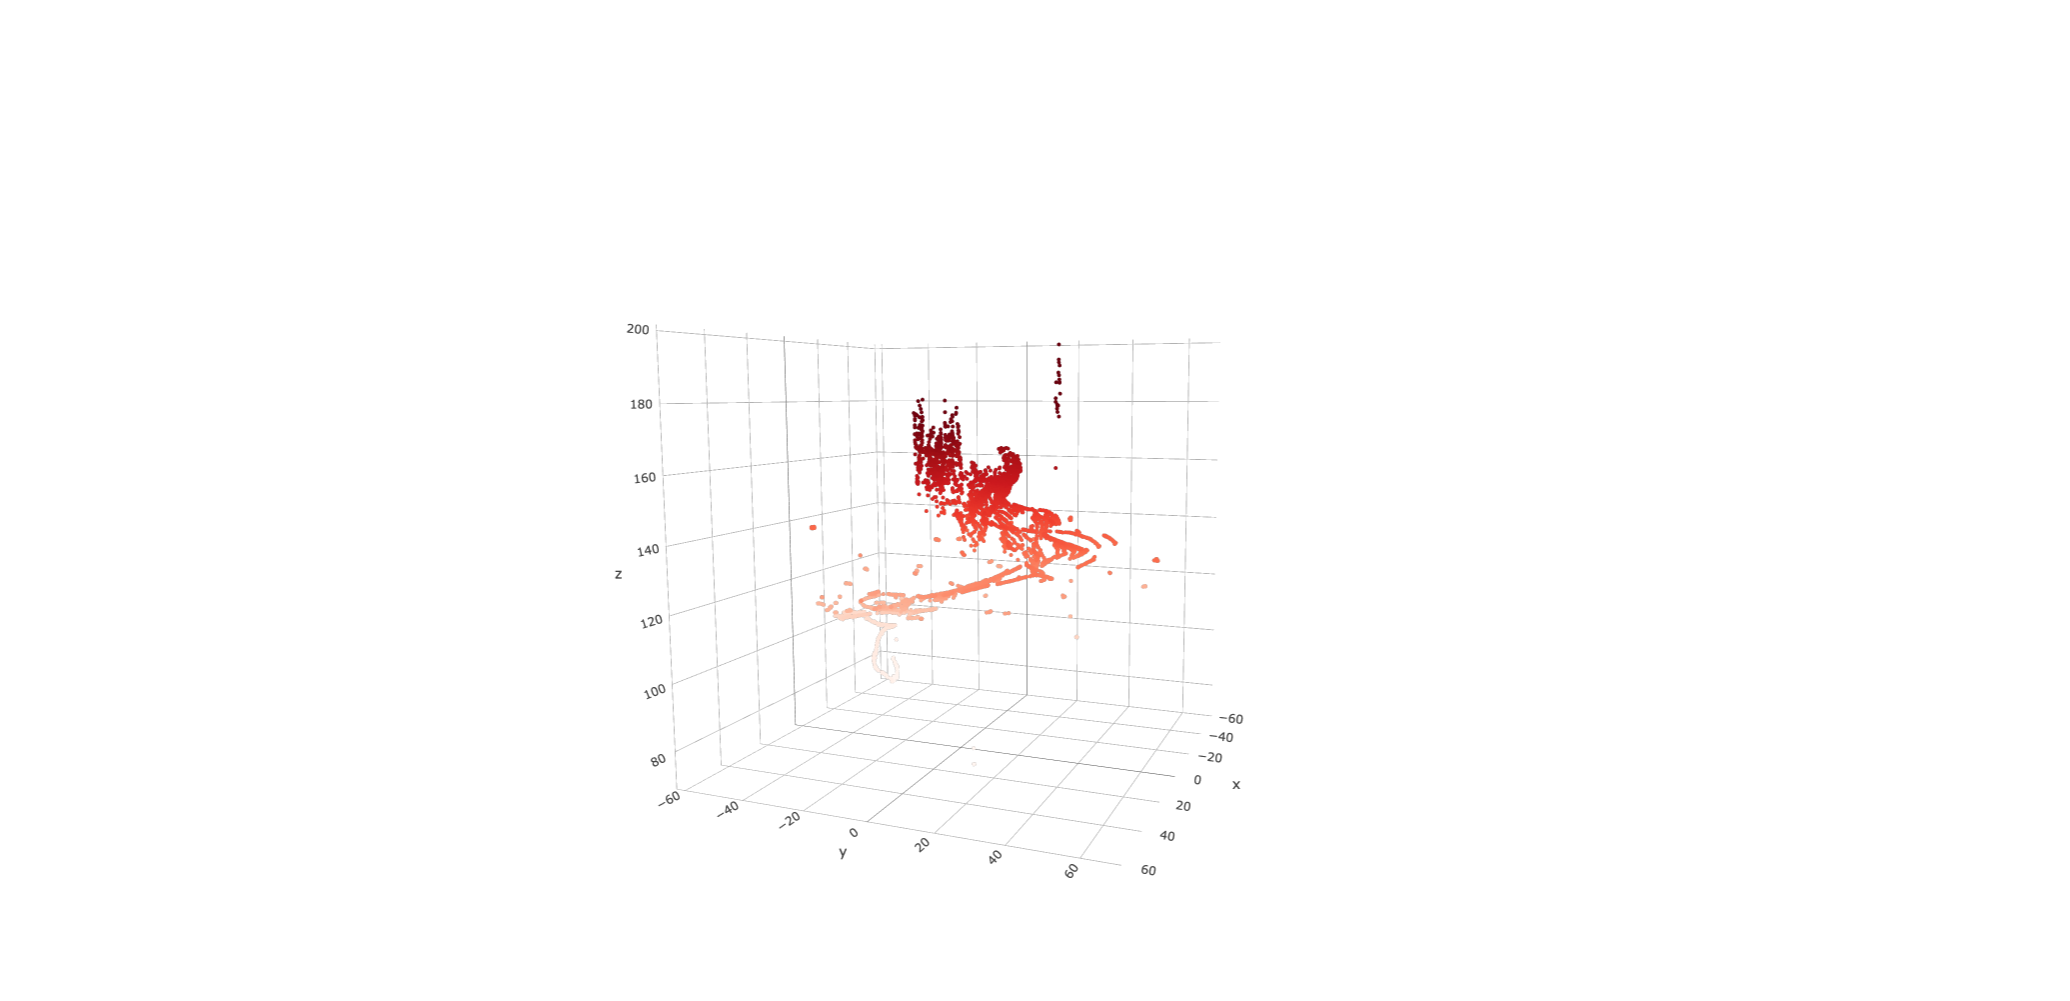

'output_plots/MIT_Landscape_UMAP_V05.html'

In [109]:
fig = pgo.Figure()
for i in umap_data_eucl:
    fig.add_trace(i)
    
fig.update_layout(template=None, height = 1000, width = 2200)
py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/MIT_Landscape_UMAP_V05.html', auto_open=False)

In [ ]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)


fig_1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | UMAP | Metric: '+ metric, 
                                                     'SPL | UMAP | Metric: '+ metric,
                                                     'Markov | UMAP | Metric: '+ metric,
                                                      'PW Euclidean | UMAP | Metric: '+ metric)
                    )

    
for i in umap_data_adj:
    fig_1.add_trace(i, row = 1, col = 1)


for i in umap_data_spl:
    fig_1.add_trace(i, row = 1, col = 2)
    
for i in umap_data_m:
    fig_1.add_trace(i, row = 1, col = 3)

for i in umap_data_eucl:
    fig_1.add_trace(i, row = 1, col = 4)

fig_1.update_layout(template='plotly_dark', height = 1000, width = 2200)
#fig_1.update_layout(template=None, height = 1000, width = 2200,)
py.iplot(fig_1)

plotly.offline.plot(fig_1, filename = 'output_plots/Landscapes_umap_'+metric+'_'+organism+'.html', auto_open=False)

### LANDSCAPE | EXPORT Coordinates x,y,z,rgba

In [110]:
organism = 'Yeast'

In [111]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [97]:
df_xyz_landscape_tsne_eucl = pd.DataFrame(posG_tsne_eucl, index=["x","y"]).T
df_xyz_landscape_tsne_eucl["z"] = z_list

In [94]:
df_xyz_landscape_tsne_eucl['r'] = colours_r
df_xyz_landscape_tsne_eucl['g'] = colours_g
df_xyz_landscape_tsne_eucl['b'] = colours_b
df_xyz_landscape_tsne_eucl['a'] = colours_a

In [95]:
df_xyz_landscape_tsne_eucl.to_csv(r'output_csv/Landscape_tsne_XYZ_PW_eucl_Dataframe_'+organism+'.csv', index = True)

In [112]:
df_xyz_landscape_umap_eucl = pd.DataFrame(posG_umap_eucl, index=["x","y"]).T
df_xyz_landscape_umap_eucl["z"] = z_list

In [113]:
df_xyz_landscape_umap_eucl['r'] = colours_r
df_xyz_landscape_umap_eucl['g'] = colours_g
df_xyz_landscape_umap_eucl['b'] = colours_b
df_xyz_landscape_umap_eucl['a'] = colours_a

In [74]:
df_xyz_landscape_umap_eucl.to_csv(r'output_csv/Landscape_umap_XYZ_PW_eucl_Dataframe_'+organism+'.csv', index = True)

In [114]:
df_xyz_landscape_umap_eucl.to_csv(r'output_csv/MIT_Landscape_UMAP_V05.csv', index = True)

## PORTRAITS

In [ ]:
prplxty3d = 50 # range: 5-50 / default = 30.#
density3d = 1.2 # default 12.
l_rate3d = 5000 # default 200.
steps3d = 1000 #min 250

metric = 'euclidean'

#### tSNE

In [ ]:
# update functions:

# e.g. embed_tsne_3D(matrix, ...) --> does not take G as input anymore 

In [ ]:
%%time
tsne_posG3d_adj = embed_tsne_3D(G, DM_adj, prplxty3d, density3d, l_rate3d, steps3d, metric)

In [ ]:
%%time
tsne_posG3d_spl = embed_tsne_3D(G, DM_spl, prplxty3d, density3d, l_rate3d, steps3d, metric)

In [ ]:
%%time
tsne_posG3d_m = embed_tsne_3D(G, DM_m, prplxty3d, density3d, l_rate3d, steps3d, metric)

In [ ]:
%%time
tsne_posG3d_eucl = embed_tsne_3D(G, DM_eucl, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time 

tsne_adj_edges = get_trace_edges(G, tsne_posG3d_adj, edge_color) 
tsne_adj_nodes = get_trace_nodes(G, tsne_posG3d_adj,  l_features, colours, size3d)
tsne_data_adj = [tsne_adj_edges, tsne_adj_nodes]

In [ ]:
%%time 

tsne_spl_edges = get_trace_edges(G, tsne_posG3d_spl, edge_color) 
tsne_spl_nodes = get_trace_nodes(G, tsne_posG3d_spl,  l_features, colours, size3d)
tsne_data_spl = [tsne_spl_edges, tsne_spl_nodes]

In [ ]:
%%time

tsne_m_edges = get_trace_edges(G, tsne_posG3d_m, edge_color) 
tsne_m_nodes = get_trace_nodes(G, tsne_posG3d_m, l_features, colours, size3d)
tsne_data_m = [tsne_m_edges, tsne_m_nodes]

In [ ]:
%%time

tsne_eucl_edges = get_trace_edges(G, tsne_posG3d_eucl, edge_color) 
tsne_eucl_nodes = get_trace_nodes(G, tsne_posG3d_eucl,l_features, colours, size3d)
tsne_data_eucl = [tsne_eucl_edges, tsne_eucl_nodes]

In [ ]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)


fig1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | tSNE | Metric: '+metric, 
                                                     'SPL | tSNE | Metric: '+metric,
                                                     'RWR | tSNE | Metric: '+metric,
                                                     'PW Euclidean | tSNE | Metric: '+metric)
                    )

    
for i in tsne_data_adj:
    fig1.add_trace(i, row = 1, col = 1)
    
#for i in tsne_data_spl:
#    fig1.add_trace(i, row = 1, col = 2)
    
for i in tsne_data_m:
    fig1.add_trace(i, row = 1, col = 3)

for i in tsne_data_eucl:
    fig1.add_trace(i, row = 1, col = 4)

#fig1.update_layout(template=None, showlegend = False, width = 2000, height = 800)
fig1.update_layout(template='plotly_dark', showlegend = False, width = 2000, height = 800)
py.iplot(fig1)

plotly.offline.plot(fig1, filename = 'output_plots/3Dportrait_tsne_'+metric+'_'+organism+'.html', auto_open=False)

#### tSNE PORTRAIT EXPORT Coordinates

In [ ]:
'''
organism = 'Yeast'


colours_rgba = []
for i in colours: 
    if i == ess_col:
        colours_rgba.append('rgba(66, 117, 154, 0.6)')
    elif i == no_ess_col:
        colours_rgba.append('rgba(162, 193, 216, 0.6)')
    else:
        colours_rgba.append('rgba(0,0,0,0.4)')
        
        
#df_xyz_rgba_3Dspring = pd.DataFrame(posG3d_spring, index=["x","y","z"]).T
#df_xyz_rgba_3Dspring['color'] = colours_rgba

df_xyz_rgba_3Dadj = pd.DataFrame(tsne_posG3d_adj, index=["x","y","z"]).T
df_xyz_rgba_3Dadj['color'] = colours_rgba

df_xyz_rgba_3Dspl = pd.DataFrame(tsne_posG3d_spl, index=["x","y","z"]).T
df_xyz_rgba_3Dspl['color'] = colours_rgba

df_xyz_rgba_3Dm = pd.DataFrame(tsne_posG3d_m, index=["x","y","z"]).T
df_xyz_rgba_3Dm['color'] = colours_rgba

df_xyz_rgba_3Deucl = pd.DataFrame(tsne_posG3d_eucl, index=["x","y","z"]).T
df_xyz_rgba_3Deucl['color'] = colours_rgba


# -----------------------------------------------

df_xyz_rgba_spring.to_csv(r'output_csv/3Dspring_XYZ_RGBA_'+organism+'.csv', index = True)

df_xyz_rgba_3Dadj.to_csv(r'output_csv/3Dportrait_tsne_XYZ_RGBA_Adjacency_'+organism+'.csv', index = True)
df_xyz_rgba_3Dspl.to_csv(r'output_csv/3Dportrait_tsne_XYZ_RGBA_SPL_'+organism+'.csv', index = True)
df_xyz_rgba_3Dm.to_csv(r'output_csv/3Dportrait_tsne_XYZ_RGBA_RWR_'+organism+'.csv', index = True)
df_xyz_rgba_3Deucl.to_csv(r'output_csv/3Dportrait_tsne_XYZ_RGBA_PW_eucl_'+organism+'.csv', index = True)
'''

#### UMAP

In [ ]:
n_neighbors = 10 # balance between local and global structure in the data
spread = 1.
min_dist = 0.1 # defines how dense points are stacked together 
metric='euclidean'

In [ ]:
%%time 
umap_posG3d_adj = embed_umap_3D(G, DM_adj, n_neighbors, spread, min_dist, metric)

In [ ]:
%%time 
umap_posG3d_spl = embed_umap_3D(G, DM_spl, n_neighbors, spread, min_dist, metric)

In [ ]:
%%time 
umap_posG3d_m = embed_umap_3D(G, DM_m, n_neighbors, spread, min_dist, metric)

In [ ]:
%%time 
umap_posG3d_eucl = embed_umap_3D(G, DM_eucl, n_neighbors, spread, min_dist, metric)

In [ ]:
%%time 
umap_adj_edges = get_trace_edges(G, umap_posG3d_adj, edge_color) 
umap_adj_nodes = get_trace_nodes(G, umap_posG3d_adj,  l_features, colours, size3d)
umap_data_adj = [umap_adj_edges, umap_adj_nodes]

In [ ]:
%%time 
umap_spl_edges = get_trace_edges(G, umap_posG3d_spl, edge_color) 
umap_spl_nodes = get_trace_nodes(G, umap_posG3d_spl,  l_features, colours, size3d)
umap_data_spl = [umap_spl_edges, umap_spl_nodes]

In [ ]:
%%time 
umap_m_edges = get_trace_edges(G, umap_posG3d_m, edge_color) 
umap_m_nodes = get_trace_nodes(G, umap_posG3d_m,  l_features, colours, size3d)
umap_data_m = [umap_m_edges, umap_m_nodes]

In [ ]:
%%time 
umap_eucl_edges = get_trace_edges(G, umap_posG3d_eucl, edge_color) 
umap_eucl_nodes = get_trace_nodes(G, umap_posG3d_eucl,  l_features, colours, size3d)
umap_data_eucl = [umap_eucl_edges, umap_eucl_nodes]

In [ ]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)

fig1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | UMAP | Metric: '+metric, 
                                                     'SPL | UMAP | Metric: '+metric,
                                                     'RWR | UMAP | Metric: '+metric,
                                                     'PW Euclidean | UMAP | Metric: '+metric)
                    )

    
for i in umap_data_adj:
    fig1.add_trace(i, row = 1, col = 1)
    
for i in umap_data_spl:
    fig1.add_trace(i, row = 1, col = 2)
    
for i in umap_data_m:
    fig1.add_trace(i, row = 1, col = 3)

for i in umap_data_eucl:
    fig1.add_trace(i, row = 1, col = 4)

fig1.update_layout(template='plotly_dark', showlegend = False, width = 2000, height = 800)
#fig1.update_layout(template=None, showlegend = False, width = 2000, height = 800)
py.iplot(fig1)

plotly.offline.plot(fig1, filename = 'output_plots/3Dportrait_umap_'+metric+'_'+organism+'.html', auto_open=False)

#### UMAP PORTRAIT Coordinates EXPORT

In [ ]:
'''
organism = 'Yeast'


colours_rgba = []
for i in colours: 
    if i == ess_col:
        colours_rgba.append('rgba(66, 117, 154, 0.6)')
    elif i == no_ess_col:
        colours_rgba.append('rgba(162, 193, 216, 0.6)')
    else:
        colours_rgba.append('rgba(0,0,0,0.4)')
        

df_xyz_rgba_3Dadj = pd.DataFrame(umap_posG3d_adj, index=["x","y","z"]).T
df_xyz_rgba_3Dadj['color'] = colours_rgba

df_xyz_rgba_3Dspl = pd.DataFrame(umap_posG3d_spl, index=["x","y","z"]).T
df_xyz_rgba_3Dspl['color'] = colours_rgba

df_xyz_rgba_3Dmlog = pd.DataFrame(umap_posG3d_mlog, index=["x","y","z"]).T
df_xyz_rgba_3Dmlog['color'] = colours_rgba

df_xyz_rgba_3Deucl = pd.DataFrame(umap_posG3d_eucl, index=["x","y","z"]).T
df_xyz_rgba_3Deucl['color'] = colours_rgba


# -----------------------------------------------

df_xyz_rgba_spring.to_csv(r'output_csv/3Dspring_XYZ_RGBA_'+organism+'.csv', index = True)

df_xyz_rgba_3Dadj.to_csv(r'output_csv/3Dportrait_umap_XYZ_RGBA_Adjacency_'+organism+'.csv', index = True)
df_xyz_rgba_3Dspl.to_csv(r'output_csv/3Dportraitumap_XYZ_RGBA_SPL_'+organism+'.csv', index = True)
df_xyz_rgba_3Dmlog.to_csv(r'output_csv/3Dportraitumap_XYZ_RGBA_RWRlog_'+organism+'.csv', index = True)
df_xyz_rgba_3Deucl.to_csv(r'output_csv/3Dportraitumap_XYZ_RGBA_PW_eucl_'+organism+'.csv', index = True)
'''

## SPHERE

#### UMAP 

In [50]:
metric = 'euclidean'

# Radius parameter
d_param = d_essentiality_scores_sorted

In [ ]:
%%time 
umap_sphere_adj = embed_umap_sphere(G, DM_adj, metric)
umap_sphere_adj_withrad = get_posG_with_sphere_radius(G, umap_sphere_adj, d_param)

In [ ]:
%%time 
umap_sphere_spl = embed_umap_sphere(G, DM_spl, metric)
umap_sphere_spl_withrad = get_posG_with_sphere_radius(G, umap_sphere_spl, d_param)

In [ ]:
%%time 
umap_sphere_m = embed_umap_sphere(G, DM_m, metric)
umap_sphere_m_withrad = get_posG_with_sphere_radius(G, umap_sphere_m, d_param)

In [51]:
%%time 
umap_sphere_eucl = embed_umap_sphere(G, DM_eucl, metric)
umap_sphere_eucl_withrad = get_posG_with_sphere_radius(G, umap_sphere_eucl, d_param)

CPU times: user 35.7 s, sys: 1.1 s, total: 36.8 s
Wall time: 20.2 s


In [ ]:
%%time 
umap_sphere_trace_adj_edges = get_trace_edges(G, umap_sphere_adj_withrad, edge_color)
umap_sphere_trace_adj_nodes = get_trace_umap_sphere(umap_sphere_adj_withrad, l_features, colours, size3d)
umap_sphere_data_adj = [umap_sphere_trace_adj_edges, umap_sphere_trace_adj_nodes]

In [ ]:
%%time
umap_sphere_trace_spl_edges = get_trace_edges(G, umap_sphere_spl_withrad, edge_color)
umap_sphere_trace_spl_nodes = get_trace_umap_sphere(umap_sphere_spl_withrad, l_features, colours, size3d)
umap_sphere_data_spl = [umap_sphere_trace_spl_edges, umap_sphere_trace_spl_nodes]

In [ ]:
%%time
umap_sphere_trace_m_edges = get_trace_edges(G, umap_sphere_m_withrad, edge_color)
umap_sphere_trace_m_nodes = get_trace_umap_sphere(umap_sphere_m_withrad, l_features, colours, size3d)
umap_sphere_data_m = [umap_sphere_trace_m_edges, umap_sphere_trace_m_nodes]

In [52]:
%%time
umap_sphere_trace_eucl_edges = get_trace_edges(G, umap_sphere_eucl_withrad, edge_color)
umap_sphere_trace_eucl_nodes = get_trace_umap_sphere(umap_sphere_eucl_withrad, l_features, colours, size3d)
umap_sphere_data_eucl = [umap_sphere_trace_eucl_edges, umap_sphere_trace_eucl_nodes]

CPU times: user 1.33 s, sys: 9.12 ms, total: 1.34 s
Wall time: 1.35 s


In [ ]:
print('Metric: ', metric)

fig = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | UMAP Sphere | Metric: '+metric, 
                                                     'SPL | UMAP Sphere | Metric: '+metric,
                                                     'RWR -log | UMAP Sphere | Metric: '+metric,
                                                     'PW Euclidean | UMAP Sphere | Metric: '+metric)
                    )

    
for i in umap_sphere_data_adj:
    fig.add_trace(i, row = 1, col = 1)
    
for i in umap_sphere_data_spl:
    fig.add_trace(i, row = 1, col = 2)
    
for i in umap_sphere_data_m:
    fig.add_trace(i, row = 1, col = 3)

for i in umap_sphere_data_eucl:
    fig.add_trace(i, row = 1, col = 4)

#fig.update_layout(template=None, showlegend = False, width = 2000, height = 800)
fig.update_layout(template='plotly_dark', showlegend = False, width = 2000, height = 800,
                 scene=dict(xaxis = dict(
                        nticks = 0, color= 'black'),
                           yaxis = dict(
                        nticks = 0, color= 'black'), 
                           zaxis = dict(
                        nticks = 0, color= 'black')))
py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dsphere_umap_'+metric+'_'+organism+'.html', auto_open=False)

### EXPORT COORDINATES

In [59]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [60]:
df_xyz_umap_3Dsphere_eucl = pd.DataFrame(umap_sphere_eucl_withrad, index=["x","y","z"]).T
df_xyz_umap_3Dsphere_eucl['r'] = colours_r
df_xyz_umap_3Dsphere_eucl['g'] = colours_g
df_xyz_umap_3Dsphere_eucl['b'] = colours_b
df_xyz_umap_3Dsphere_eucl['a'] = colours_a

df_xyz_umap_3Dsphere_eucl.to_csv(r'output_csv/3Dsphere_umap_XYZRGBA_PW_eucl_'+organism+'.csv', index = True)

# POTENTIALLY ADD

### STELLAR GRAPH 
+https://github.com/stellargraph/stellargraph

+https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html

In [ ]:
import stellargraph as sg
import tensorflow as tf

In [ ]:
nodes = G.nodes()
edges = G.edges()

In [ ]:
# Graph machine learning model 

graph = sg.StellarGraph.from_networkx(G)

generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn")

# two layers of GCN, each with hidden dimension 16
gcn = sg.layer.GCN(layer_sizes=[16, 16], generator=generator)
x_inp, x_out = gcn.in_out_tensors() # create the input and output TensorFlow tensors

# use TensorFlow Keras to add a layer to compute the (one-hot) predictions
predictions = tf.keras.layers.Dense(units=len(ground_truth_targets.columns), activation="softmax")(x_out)

In [ ]:
# Training and evaluation 


# prepare the model for training with the Adam optimiser and an appropriate loss function
model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

# train the model on the train set
model.fit(generator.flow(train_targets.index, train_targets), epochs=5)

# check model generalisation on the test set
(loss, accuracy) = model.evaluate(generator.flow(test_targets.index, test_targets))
print(f"Test set: loss = {loss}, accuracy = {accuracy}")

In [ ]:
# algorithms to use: GraphSAGE, node2vec, Metapath2Vec

#### DOSNES

In [ ]:
# tSNE optimization 

momentum = 0.1 # default 0.1
final_momentum = 0.9 # default 0.7
max_iter = 10
learning_rate = 1000
min_gain = 1. #default 0.01

In [ ]:
%%time 

embedded_adj = embed_tsne_sphere(G, DM_adj, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_spl = embed_tsne_sphere(G, DM_spl, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_mlog = embed_tsne_sphere(G, DM_m, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_eucl = embed_tsne_sphere(G, DM_eucl, momentum, final_momentum, learning_rate, min_gain, max_iter)

In [ ]:
# choose radius parameter for layout

# dict param should be : {NODE ID: VALUE}
dict_param = d_essentiality_scores_sorted

d_node_rad = assign_radius_to_nodes(G, dict_param)  

l_rad = list(set(d_node_rad.values()))
spheres_back = get_sphere_background(l_rad)

In [ ]:
%%time 


trace_nodes_adj = get_tsne_sphere_trace_nodes(embedded_adj, d_node_rad, colours, size3d)
#trace_edges_adj = get_trace_edges(G, embedded_adj, edge_color)
data_adj = [trace_nodes_adj] #, trace_edges_adj]

trace_nodes_spl = get_tsne_sphere_trace_nodes(embedded_spl, d_node_rad, colours, size3d)
data_spl = [trace_nodes_spl]

trace_nodes_mlog = get_tsne_sphere_trace_nodes(embedded_mlog, d_node_rad, colours, size3d)
data_mlog = [trace_nodes_mlog]

trace_nodes_eucl = get_tsne_sphere_trace_nodes(embedded_eucl, d_node_rad, colours, size3d)
data_eucl = [trace_nodes_eucl]

In [ ]:
print('Momentum:', momentum)
print('Final Momentum:', final_momentum)
print('Max.Iterations:', max_iter)
print('Learning rate:', learning_rate)
print('Min.Gain:', min_gain)


fig_s1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | DOSNES', 
                                                     'SPL | DOSNES',
                                                     'Markov -log | DOSNES', 
                                                     'PW Euclidean | DOSNES')
                    )

    
for i in data_adj:
    fig_s1.add_trace(i, row = 1, col = 1)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 1)
    
for i in data_spl:
    fig_s1.add_trace(i, row = 1, col = 2)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 2)
    
for i in data_m:
    fig_s1.add_trace(i, row = 1, col = 3)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 3)

for i in data_mlog:
    fig_s1.add_trace(i, row = 1, col = 4)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 4)
    
fig_s1.update_layout(template = "plotly_dark", height = 800, width = 2000)
py.iplot(fig_s1)

plotly.offline.plot(fig_s1, filename = 'output_plots/3D_dosnes_spheres_'+organism+'.html', auto_open=False)

### EXPORT Coordinates x,y,z,rgba

In [ ]:
'''
organism = 'Yeast'


colours_rgba = []
for i in colours: 
    if i == ess_col:
        colours_rgba.append('rgba(66, 117, 154, 0.6)')
    elif i == no_ess_col:
        colours_rgba.append('rgba(162, 193, 216, 0.6)')
    else:
        colours_rgba.append('rgba(0,0,0,0.4)')
        

df_xyz_rgba_sphere_adj = pd.DataFrame(embedded_adj, index=["x","y","z"]).T
df_xyz_rgba_sphere_adj['color'] = colours_rgba

df_xyz_rgba_sphere_spl = pd.DataFrame(embedded_spl, index=["x","y","z"]).T
df_xyz_rgba_sphere_spl['color'] = colours_rgba

df_xyz_rgba_sphere_m = pd.DataFrame(embedded_m, index=["x","y","z"]).T
df_xyz_rgba_sphere_m['color'] = colours_rgba

df_xyz_rgba_sphere_mlog = pd.DataFrame(embedded_mlog, index=["x","y","z"]).T
df_xyz_rgba_sphere_mlog['color'] = colours_rgba



df_xyz_rgba_sphere_cos = pd.DataFrame(embedded_cos, index=["x","y","z"]).T
df_xyz_rgba_sphere_cos['color'] = colours_rgba

df_xyz_rgba_sphere_eucl = pd.DataFrame(embedded_eucl, index=["x","y","z"]).T
df_xyz_rgba_sphere_eucl['color'] = colours_rgba

df_xyz_rgba_sphere_sqeucl = pd.DataFrame(embedded_sqeucl, index=["x","y","z"]).T
df_xyz_rgba_sphere_sqeucl['color'] = colours_rgba

df_xyz_rgba_sphere_corr = pd.DataFrame(embedded_corr, index=["x","y","z"]).T
df_xyz_rgba_sphere_corr['color'] = colours_rgba


# -----------------------------------------------

df_xyz_rgba_sphere_adj.to_csv(r'output_csv/3DSphere_XYZ_RGBA_Adjacency_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_spl.to_csv(r'output_csv/3DSphere_XYZ_RGBA_SPL'+organism+'.csv', index = True)
df_xyz_rgba_sphere_m.to_csv(r'output_csv/3DSphere_XYZ_RGBA_RWR_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_mlog.to_csv(r'output_csv/3DSphere_XYZ_RGBA_RWRlog_'+organism+'.csv', index = True)

df_xyz_rgba_sphere_cos.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_cos_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_eucl.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_eucl_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_sqeucl.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_sqeucl_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_corr.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_corr_'+organism+'.csv', index = True)
'''

## TORUS

#### UMAP

In [ ]:
%%time 
umap_torus_adj = umap.UMAP(output_metric=torus_euclidean_grad, random_state=42).fit(DM_adj)

In [ ]:
%%time 
umap_torus_spl = umap.UMAP(output_metric=torus_euclidean_grad, random_state=42).fit(DM_spl)

In [ ]:
%%time 
umap_torus_mlog = umap.UMAP(output_metric=torus_euclidean_grad, random_state=42).fit(DM_mlog)

In [ ]:
%%time 
umap_torus_eucl = umap.UMAP(output_metric=torus_euclidean_grad, random_state=42).fit(DM_eucl)

In [ ]:
r_crosssection = 1
R_torussize = 3

torus_trace_adj = get_trace_umap_torus(umap_torus_adj, r_crosssection, R_torussize, colours)
umap_torus_data_adj = [torus_trace_adj] 

torus_trace_spl = get_trace_umap_torus(umap_torus_spl, r_crosssection, R_torussize, colours)
umap_torus_data_spl = [torus_trace_spl] 

torus_trace_mlog = get_trace_umap_torus(umap_torus_mlog, r_crosssection, R_torussize, colours)
umap_torus_data_mlog = [torus_trace_mlog] 

torus_trace_eucl = get_trace_umap_torus(umap_torus_eucl, r_crosssection, R_torussize, colours)
umap_torus_data_eucl = [torus_trace_eucl] 

In [ ]:
fig1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency | UMAP', 
                                                     'SPL | UMAP',
                                                     'RWR -log | UMAP',
                                                     'PW Euclidean | UMAP')
                    )

    
for i in umap_torus_data_adj:
    fig1.add_trace(i, row = 1, col = 1)
    
for i in umap_torus_data_spl:
    fig1.add_trace(i, row = 1, col = 2)
    
for i in umap_torus_data_mlog:
    fig1.add_trace(i, row = 1, col = 3)

for i in umap_torus_data_eucl:
    fig1.add_trace(i, row = 1, col = 4)

#fig1.update_layout(template=None, showlegend = False, width = 2000, height = 800)
fig1.update_layout(template='plotly_dark', showlegend = False, width = 2000, height = 800)
py.iplot(fig1)

plotly.offline.plot(fig1, filename = 'output_plots/3D_umap_torus_'+organism+'.html', auto_open=False)